## DATASET

In [15]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

Loading the MNIST and Fashion MNIST dataset

In [3]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
print()

print('Shape MNIST train:', np.shape(mnist_x_train))
print('Shape Fashion MNIST train:', np.shape(fashion_mnist_x_train))
print()

# Normalization and Padding
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape MNIST train after padding:', np.shape(mnist_x_train))
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape Fashion MNIST train after padding:', np.shape(mnist_x_train))

Shape MNIST train: (60000, 28, 28)
Shape Fashion MNIST train: (60000, 28, 28)

Shape MNIST train after padding: (60000, 32, 32)
Shape Fashion MNIST train after padding: (60000, 32, 32)


In [4]:
print(f'Number of MNIST/fashion MNIST training samples: {np.shape(mnist_x_train)[0]}')
print(f'Number of MNIST/fashion MNIST test samples: {np.shape(mnist_x_test)[0]}')
print(f'MNIST/fashion MNIST resolution: {np.shape(mnist_x_test)[1:]}')

Number of MNIST/fashion MNIST training samples: 60000
Number of MNIST/fashion MNIST test samples: 10000
MNIST/fashion MNIST resolution: (32, 32)


Only one channel (grey-scale images).

In [6]:
N_train, h, w = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0]

### Data generator
Generator which generates batches. A batch is a couple `x_batch, y_batch`, containing `batchsize` number of samples. `x_batch` represents the input, and it contains images `x`: each image `x` has spatial dimensions $32*32$ and it contains a pair of MNIST-fashion MNIST images added together. `y_batch` represents the ground truth, and it contains the images `y`: each image `y` has spatial dimensions $32*64$ and it contains the same pair of MNIST-fashion MNIST images concatenated along the width.

In [7]:
def datagenerator(x1, x2, batchsize):
    # x1: first dataset of images. In our case, MNIST dataset (either train or test)
    # x2: second dataset of images. In our case, fashion MNIST dataset (either train or test)

    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_batch = (x1[num1] + x2[num2]) / 2.0
        y_batch = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_batch, y_batch 

In [8]:
batchsize = 64

In [10]:
# Generator for creating the training batches
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize)

# Generator for creating the validation batches
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize)

Example of a training batch

In [11]:
x_batch, y_batch = next(train_generator)
print('Shape of the x_batch:', x_batch.shape)
print('Shape of the y_batch:', y_batch.shape)

Shape of the x_batch: (64, 32, 32)
Shape of the y_batch: (64, 32, 64)


The data is already normalized into $[0,1]$

In [12]:
x_batch[0].min(), x_batch[0].max()

(0.0, 0.8313725490196078)

In [13]:
y_batch[0].min(), y_batch[0].max()

(0.0, 1.0)

Visualization of a sample in the batch

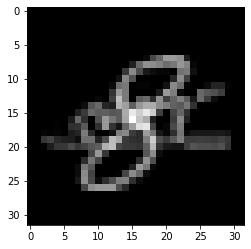

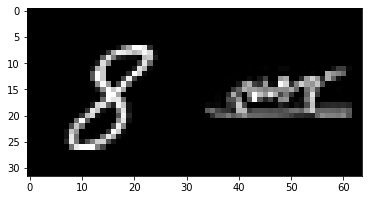

In [16]:
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()

## MODEL
Fully convolutional autoencoder. One single encoder and one single decoder. Input: $32*32*1$. Output: $32*64*1$.

In [17]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras import Model

In [18]:
# Dimensions of the input: 32*32*1=1024
xin = Input(shape=(32, 32, 1))

# ENCODER
x = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(xin)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
# Latent encoding dimensions: 4*4*64=1024
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)

# DECODER
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x)
x = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same')(x)

# Dimensions of the output: 32*64*1
y = Conv2DTranspose(filters=1, kernel_size=3, strides=(1,2), padding='same', activation='sigmoid')(x)

nn = Model(inputs=xin, outputs=y)

In [19]:
nn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 32)         18464     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 16)       4624      
 ranspose)                                                   

### Training

In [20]:
from tensorflow.keras.optimizers import Adam

In [21]:
nn.compile(optimizer=Adam(), loss='mse')

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback_checkpoint = ModelCheckpoint('CNN.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [36]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [37]:
hist = nn.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 56s 59ms/step - loss: 0.0532 - val_loss: 0.0318
Epoch 2/15
937/937 [==============================] - 56s 60ms/step - loss: 0.0300 - val_loss: 0.0288
Epoch 3/15
937/937 [==============================] - 56s 60ms/step - loss: 0.0278 - val_loss: 0.0270
Epoch 4/15
937/937 [==============================] - 54s 58ms/step - loss: 0.0268 - val_loss: 0.0263
Epoch 5/15
937/937 [==============================] - 56s 59ms/step - loss: 0.0261 - val_loss: 0.0258
Epoch 6/15
937/937 [==============================] - 55s 59ms/step - loss: 0.0258 - val_loss: 0.0254
Epoch 7/15
937/937 [==============================] - 58s 62ms/step - loss: 0.0254 - val_loss: 0.0252
Epoch 8/15
937/937 [==============================] - 56s 60ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 9/15
937/937 [==============================] - 54s 58ms/step - loss: 0.0248 - val_loss: 0.0250
Epoch 10/15
937/937 [==============================] - 57s 61ms/step - loss: 0.024

Score: around $0.024$.

In [39]:
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

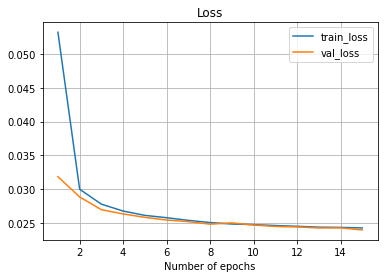

In [40]:
plot_history(hist)

Very smooth curve: no overfitting

### Visualization of some results

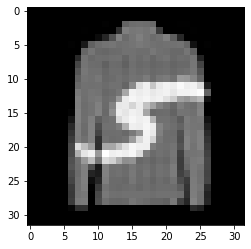

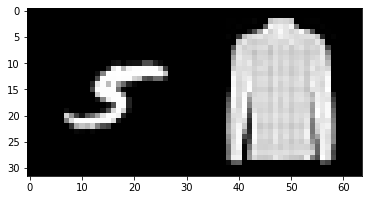

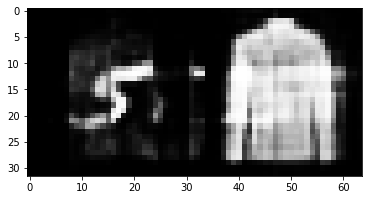

In [49]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

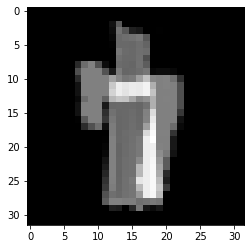

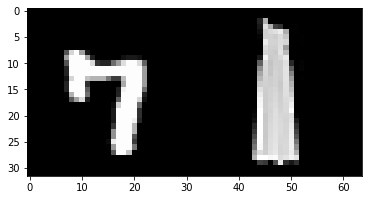

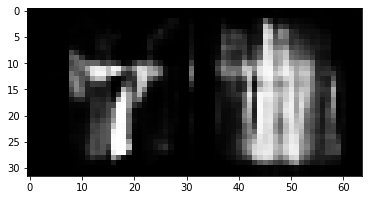

In [50]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

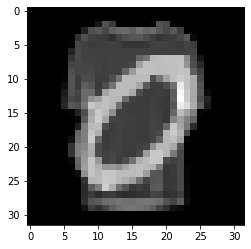

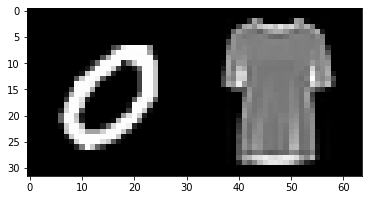

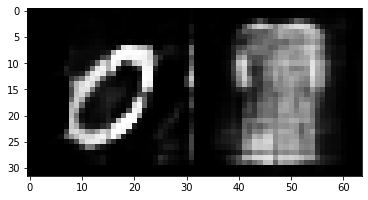

In [51]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()